**Import necessary Libraries**

In [121]:
# Import all necessary libraries
import numpy as np
from keras.optimizers import Adam
from sklearn.metrics import classification_report                              
from skimage import data, io  
import pandas as pd  
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, precision_recall_curve, auc                 
import matplotlib.pyplot as plt                  
import warnings
import cv2
from google.colab.patches import cv2_imshow     
from keras.utils import to_categorical
from google.colab import drive
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, MaxPool2D, GlobalMaxPooling2D, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import numpy as np
import os
import keras
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras import datasets, models, layers, optimizers
from tensorflow.keras import regularizers
warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

In [122]:
# Mount Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [123]:
# Set the path to images stored in npz, labels in csv and set path to store the model
images_path = "/content/drive/My Drive/ImageProcessing/solution/images.npy"
labels_path = "/content/drive/My Drive/ImageProcessing/solution/Labels.csv"
model_path = "/content/drive/My Drive/ImageProcessing/solution/vgg16_1.h5"

In [124]:
# Correct version of tensorflow
print(tf.__version__)

2.4.1


In [125]:
# Load images and labels, images are already in a numpy array and convert labels to numpy array
images = np.load(images_path)
images_label1 = pd.read_csv(labels_path)
#images_label = images_label1.to_numpy()

In [126]:
# The image shape shows 4750 rows, color image of 128 X 128
images.shape

(4750, 128, 128, 3)

In [127]:
# The image label shape shows 4750 rows
images_label1.shape

(4750, 1)

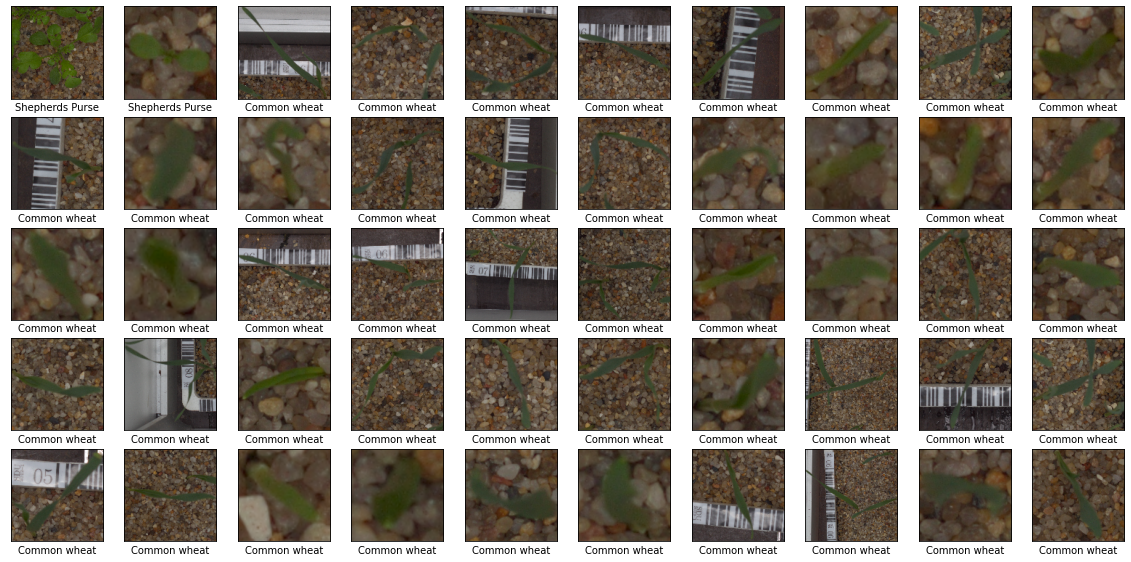

In [128]:
# Displaying some images
plt.figure(figsize=(20,20))
j = 0
for i in range(1200,1250):
    plt.subplot(10,10, j + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB))
    plt.xlabel(images_label1.iloc[i,0])
    j = j + 1
plt.show()

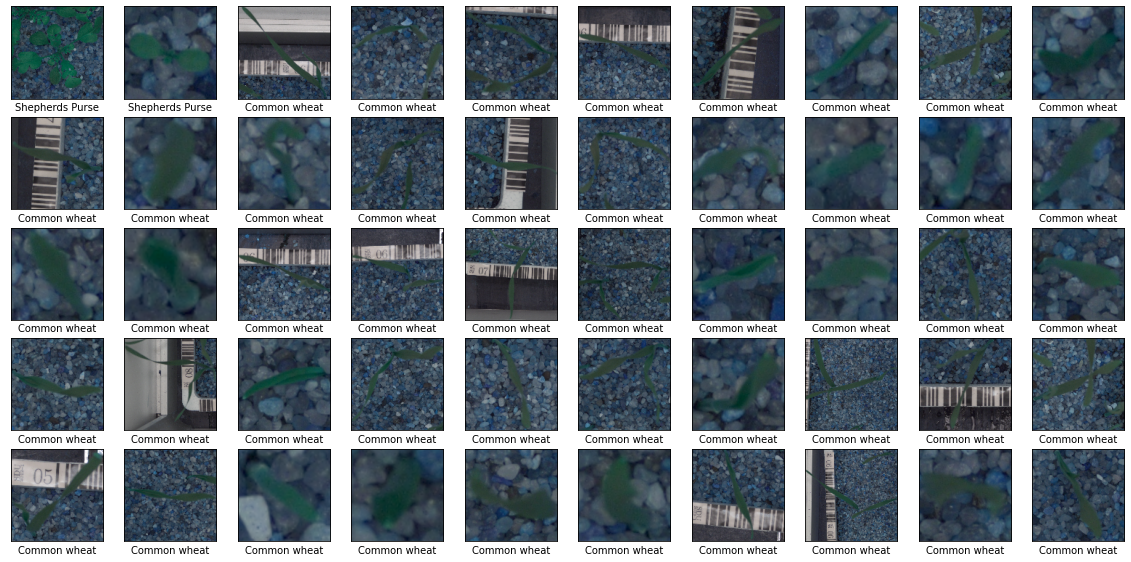

In [129]:
# Grayscaling the same images
plt.figure(figsize=(20,20))
j = 0
for i in range(1200,1250):
    plt.subplot(10,10, j + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(images[i], cmap=plt.cm.binary)
    plt.xlabel(images_label1.iloc[i,0])
    j = j + 1
plt.show()

In [130]:
# Displaying min and max image value for the first image
print(f"The image has a minimum size of {images[0].min()} and a maximum size of {images[0].max()}")

The image has a minimum size of 2 and a maximum size of 167


In [131]:
# Displaying type and datatype of the image array, not yet in float32
print(type(images))
print(images.dtype)

<class 'numpy.ndarray'>
uint8


In [132]:
# Scaling the image array by converting to float 32 and dividing by max value of 255
images_scaled = images.astype('float32') / 255.0 
print(images_scaled.dtype)

float32


In [133]:
# Displaying min and max scaled values
print(f"After scaling the image has a minimum size of {images_scaled[0].min()} and a maximum size of {images_scaled[0].max()}")

After scaling the image has a minimum size of 0.007843137718737125 and a maximum size of 0.6549019813537598


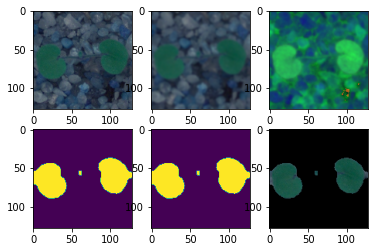

In [134]:
# Preparing the image dataset by blurring and removing the background
perfect_image = []
flag = True
for img in images:
    # Use gaussian blur
    blurImg = cv2.GaussianBlur(img, (5, 5), 0)   
    
    # Convert to HSV image
    hsvImg = cv2.cvtColor(blurImg, cv2.COLOR_BGR2HSV)  
    
    # Create mask (
    lower_green = (25, 40, 50)
    upper_green = (75, 255, 255)
    mask = cv2.inRange(hsvImg, lower_green, upper_green)  
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11, 11))
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    
    # Create bool mask
    bMask = mask > 0  
    
    # Apply the mask
    clear = np.zeros_like(img, np.uint8)  
    clear[bMask] = img[bMask]  
    perfect_image.append(clear)  
    
    # Some examples
    if flag:
        plt.subplot(2, 3, 1); plt.imshow(img)  
        plt.subplot(2, 3, 2); plt.imshow(blurImg) 
        plt.subplot(2, 3, 3); plt.imshow(hsvImg)  
        plt.subplot(2, 3, 4); plt.imshow(mask)  
        plt.subplot(2, 3, 5); plt.imshow(bMask)  
        plt.subplot(2, 3, 6); plt.imshow(clear)  
        flag = False

blurred_image = np.asarray(perfect_image)

In [135]:
# Displaying the shape of a blurred image
blurred_image[0].shape

(128, 128, 3)

In [136]:
blurred_image.shape

(4750, 128, 128, 3)

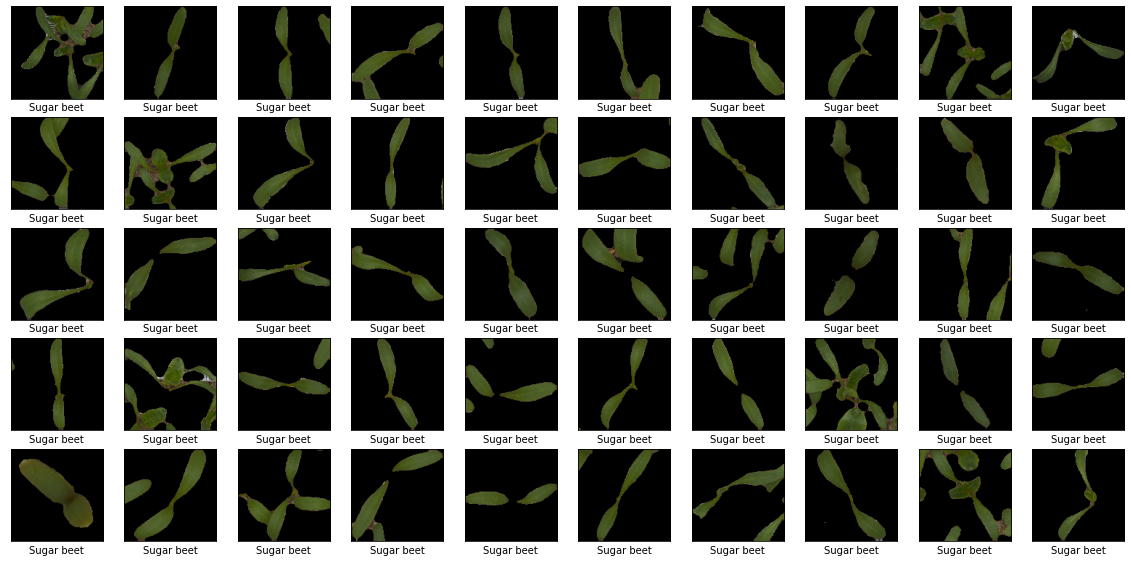

In [137]:
# Displaying a few perfected images to be used by the model
plt.figure(figsize=(20,20))
j = 0
for i in range(3500,3550):
    plt.subplot(10,10, j + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(cv2.cvtColor(blurred_image[i], cv2.COLOR_BGR2RGB))
    plt.xlabel(images_label1.iloc[i,0])
    j = j + 1
plt.show()

['Small-flowered Cranesbill' 'Fat Hen' 'Shepherds Purse' 'Common wheat'
 'Common Chickweed' 'Charlock' 'Cleavers' 'Scentless Mayweed' 'Sugar beet'
 'Maize' 'Black-grass' 'Loose Silky-bent']
[ 0  1  2  3  4  5  6  7  8  9 10 11]


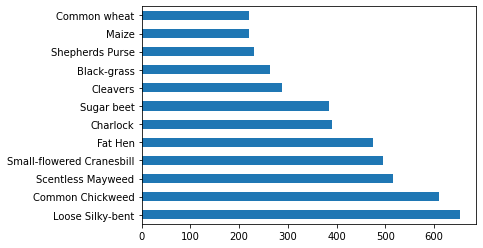

In [138]:
# Displaying label names, integer assignment and distribution
#labels = pd.read_csv(labels_path)
images_label1.shape
class_names = images_label1.iloc[:,0].unique()
print(class_names)
class_index = images_label1['Label'].apply(lambda x: 0 if x == 'Small-flowered Cranesbill' else 1 if x == 'Fat Hen' else 2 if x == 'Shepherds Purse' else 3 if x == 'Common wheat' else 4 if x == 'Common Chickweed' else 5 if x == 'Charlock' else 6 if x == 'Cleavers' else 7 if x == 'Scentless Mayweed' else 8 if x == 'Sugar beet' else 9 if x == 'Maize' else 10 if x == 'Black-grass' else 11)
print(class_index.unique())
images_label1['Label'].value_counts().plot(kind='barh')

In [139]:
# Creating the training, validation and testing set according to the instructions 70/30 and 50/50

enc = LabelBinarizer()
le = LabelEncoder()

# Scaling the data
train_data = blurred_image.astype("float32") / 255.0

# One hot encoding using LabelBinarizer, could have also used keras to_categorical
images_label1 = le.fit_transform(images_label1["Label"])
images_label1 = enc.fit_transform(images_label1) 





X_train, X_test, y_train, y_test = train_test_split(train_data, images_label1, test_size=0.30, random_state=42)

X_tests, X_val, y_tests, y_val = train_test_split(X_test, y_test, test_size=0.50, random_state=42)





In [141]:
# Displaying the binary matrix after one hot encoding
print(y_train[0])

[0 0 1 0 0 0 0 0 0 0 0 0]


In [142]:
# the following cells display the shape of the various imge datasets
X_tests.shape

(712, 128, 128, 3)

In [143]:
X_val.shape

(713, 128, 128, 3)

In [144]:
X_train.shape

(3325, 128, 128, 3)

In [145]:
y_tests.shape

(712, 12)

In [146]:
y_train.shape

(3325, 12)

In [147]:
y_val.shape

(713, 12)

In [148]:
# Below please find the model and model summary with Trainable params: 8,560,460
model = Sequential()

model.add(Conv2D(filters=64, kernel_size=(5, 5), input_shape=X_train.shape[1:], activation='relu'))
model.add(BatchNormalization(axis=3))
model.add(Conv2D(filters=64, kernel_size=(5, 5), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization(axis=3))
model.add(Dropout(0.1))

model.add(Conv2D(filters=128, kernel_size=(5, 5), activation='relu'))
model.add(BatchNormalization(axis=3))
model.add(Conv2D(filters=128, kernel_size=(5, 5), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization(axis=3))
model.add(Dropout(0.1))

model.add(Conv2D(filters=256, kernel_size=(5, 5), activation='relu'))
model.add(BatchNormalization(axis=3))
model.add(Conv2D(filters=256, kernel_size=(5, 5), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization(axis=3))
model.add(Dropout(0.1))

model.add(layers.GlobalMaxPooling2D())

model.add(Dense(256, activation='relu', bias_regularizer=regularizers.l2(1e-4),
    activity_regularizer=regularizers.l2(1e-5)))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(256, activation='relu', bias_regularizer=regularizers.l2(1e-4),
    activity_regularizer=regularizers.l2(1e-5)))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(12, activation='softmax'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 124, 124, 64)      4864      
_________________________________________________________________
batch_normalization_16 (Batc (None, 124, 124, 64)      256       
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 120, 120, 64)      102464    
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 60, 60, 64)        0         
_________________________________________________________________
batch_normalization_17 (Batc (None, 60, 60, 64)        256       
_________________________________________________________________
dropout_10 (Dropout)         (None, 60, 60, 64)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 56, 56, 128)      

In [149]:
# Compiling the model using the Adam optimizer and a learning rate of 0.001
opt = Adam(lr=0.001)
model.compile(optimizer=opt, loss=keras.losses.categorical_crossentropy, metrics=['accuracy'])

In [150]:
# Implementing callbacks to save the model and stop when further gains are not attainable, in addition fitting the model 
checkpoint = ModelCheckpoint("/content/drive/My Drive/ImageProcessing/solution/vgg16_1.h5", monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
early = EarlyStopping(monitor='val_accuracy', min_delta=0.001, patience=20, verbose=1, mode='auto')
hist = model.fit(X_train, y_train, steps_per_epoch=100, validation_data=(X_val, y_val), validation_steps=10,epochs=100,callbacks=[checkpoint,early])


Epoch 1/100
100/100 [==============================] - 15s 133ms/step - loss: 2.6666 - accuracy: 0.2711 - val_loss: 6.0955 - val_accuracy: 0.1360

Epoch 00001: val_accuracy improved from -inf to 0.13604, saving model to /content/drive/My Drive/ImageProcessing/solution/vgg16_1.h5
Epoch 2/100
100/100 [==============================] - 13s 131ms/step - loss: 1.6851 - accuracy: 0.4625 - val_loss: 6.5188 - val_accuracy: 0.1346

Epoch 00002: val_accuracy did not improve from 0.13604
Epoch 3/100
100/100 [==============================] - 13s 131ms/step - loss: 1.3532 - accuracy: 0.5673 - val_loss: 7.4376 - val_accuracy: 0.1543

Epoch 00003: val_accuracy improved from 0.13604 to 0.15428, saving model to /content/drive/My Drive/ImageProcessing/solution/vgg16_1.h5
Epoch 4/100
100/100 [==============================] - 13s 132ms/step - loss: 1.1063 - accuracy: 0.6601 - val_loss: 6.3884 - val_accuracy: 0.1459

Epoch 00004: val_accuracy did not improve from 0.15428
Epoch 5/100
100/100 [============

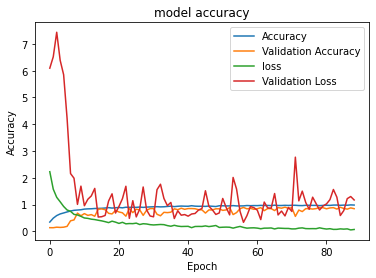

In [151]:
# Visualizing model metrics
plt.plot(hist.history["accuracy"])
plt.plot(hist.history['val_accuracy'])
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title("model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Accuracy","Validation Accuracy","loss","Validation Loss"])
plt.show()

In [152]:
# Evaluating the model against the test data
model.load_weights(model_path)
eval_results = model.evaluate(X_tests, y_tests)
print("[test loss, test accuracy]:", eval_results)

23/23 [==============================] - 1s 34ms/step - loss: 0.4555 - accuracy: 0.8947
[test loss, test accuracy]: [0.45551779866218567, 0.8946629166603088]


In [153]:
# Predicting and displaying the confusion matrix
Y_pred = model.predict_classes(X_tests)
rounded_labels=np.argmax(y_tests, axis=1)
cm = confusion_matrix(rounded_labels, Y_pred)
print(cm)


[[22  0  0  0  2  0 17  0  0  0  0  0]
 [ 0 51  1  0  0  0  0  0  2  0  1  0]
 [ 0  4 42  1  0  0  0  0  0  0  2  0]
 [ 0  0  0 86  0  1  0  0  0  0  1  0]
 [ 1  0  0  0 25  1  5  1  0  0  0  0]
 [ 0  0  0  0  0 73  0  0  0  0  1  0]
 [ 9  0  0  0  0  0 91  0  0  0  1  0]
 [ 0  0  0  0  0  1  0 29  0  0  0  0]
 [ 0  0  0  0  0  0  1  0 72  0  0  1]
 [ 0  1  0  4  0  0  0  0  9 30  4  0]
 [ 0  0  0  0  0  0  0  1  0  0 71  0]
 [ 0  0  0  0  0  1  0  1  0  0  0 45]]


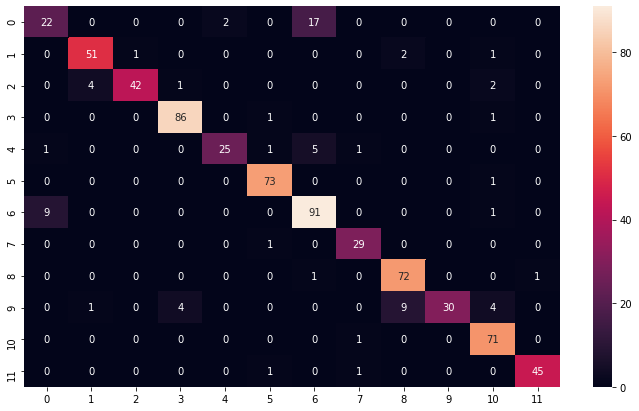

In [154]:
# Different visual of confusion matrix -- heatmap
import seaborn as sns
df_cm = pd.DataFrame(cm, index = [i for i in range(12)],
                     columns = [i for i in range(12)])
plt.figure(figsize = (12,7))
sns.heatmap(df_cm, annot=True, fmt='d')

In [155]:
# Displaying the classification report, good scores for recall, precision and f1 score
print("=== Classification Report ===")
print(classification_report(rounded_labels, Y_pred))

=== Classification Report ===
              precision    recall  f1-score   support

           0       0.69      0.54      0.60        41
           1       0.91      0.93      0.92        55
           2       0.98      0.86      0.91        49
           3       0.95      0.98      0.96        88
           4       0.93      0.76      0.83        33
           5       0.95      0.99      0.97        74
           6       0.80      0.90      0.85       101
           7       0.91      0.97      0.94        30
           8       0.87      0.97      0.92        74
           9       1.00      0.62      0.77        48
          10       0.88      0.99      0.93        72
          11       0.98      0.96      0.97        47

    accuracy                           0.89       712
   macro avg       0.90      0.87      0.88       712
weighted avg       0.90      0.89      0.89       712



In [160]:
picarr = [2,3,33,36,59]

for i in picarr:
  print(f"Predict {i}: {Y_pred[i]}")
  print(f"Actual {i}: {np.argmax(y_tests[i])}")



Predict 2: 6
Actual 2: 6
Predict 3: 3
Actual 3: 3
Predict 33: 4
Actual 33: 4
Predict 36: 4
Actual 36: 4
Predict 59: 10
Actual 59: 10
